### Load Required Libraries here


In [1]:
import os
import numpy as np
np.random.seed(111)
import pandas as pd
from keras import layers
from keras import models
from keras import metrics
from keras import optimizers
from keras import callbacks
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
import matplotlib.pyplot as plot
from sklearn import model_selection
from sklearn import preprocessing


Using TensorFlow backend.


##  Read Train & Test Data and replace NA values

In [2]:
path = os.getcwd()
os.listdir()

['.ipynb_checkpoints',
 'AttributeDescription.pdf',
 'best_mlp_embedded_model.h5',
 'best_mlp_one_hot_encoded_model.h5',
 'best_simple_RNN_embedded_model.h5',
 'CUTe_CSE7321c_Batch39_Group_2.pptx',
 'CUTe_CSE7321c_Batch39_Group_2.zip',
 'Document Classification With One Hot Encoding.ipynb',
 'Document Classification With Pre-Trained Embedding.ipynb',
 'Document Classification With Word Embedding.ipynb',
 'test.csv',
 'test_mlp_embedded_model.csv',
 'test_simple_RNN_embedded_model.csv',
 'train.csv',
 '~$CUTe_CSE7321c_Batch39_Group_2.pptx']

In [3]:
train = pd.read_csv("train.csv", index_col = "ID", na_values=" ")
test = pd.read_csv("test.csv", na_values=" ")

In [4]:
train[train.isnull().any(axis=1)]
test[test.isnull().any(axis=1)]

,ID,converse
2811,14194,NaN
3603,18173,NaN
4447,22293,NaN
6261,31275,NaN
6737,33762,NaN
9539,47537,NaN
9702,48370,NaN


In [5]:
train["converse"] = train["converse"].astype(str)
test["converse"] = test["converse"].astype(str)

## Tokenize & Vectorize Data using One-Hot Encoding

In [6]:
train_data = train["converse"]
test_data = test["converse"]

In [7]:
max_words = 10000

In [8]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)

In [9]:
def vectorize_label_data(data, column):
    data[column] = data[column].astype("category")
    return np_utils.to_categorical(data[column].cat.codes.values)

def create_test_submission_file(test_preds, fileName):
    label_index_map = dict(enumerate(train['categories'].cat.categories))
    test['categories'] = test_preds
    test['categories'] = test['categories'].map(label_index_map)
    test[["ID", "categories"]].to_csv(fileName, index=False)  

def plotTrainValidationAccuracy(model_history, name):
    plot.clf()
    history_dict = model_history.history
    train_acc = history_dict["acc"]
    val_acc = history_dict["val_acc"]
    epocs = range(1, len(train_acc) + 1)
    plot.plot(epocs, train_acc, "go", label = "Training Accuracy")
    plot.plot(epocs, val_acc, "g", label = "Validation Accuracy")
    plot.title(name + " Training & validation accuracy")
    plot.xlabel("Epocs")
    plot.ylabel("Accuracy")
    plot.legend()
    plot.show()
    

In [10]:
train_vectorized = tokenizer.texts_to_matrix(train_data)
label_vectorized = vectorize_label_data(train, "categories")
test_vectorized = tokenizer.texts_to_matrix(test_data)

In [11]:
print(train_vectorized.shape)
print(test_vectorized.shape)
print(label_vectorized.shape)

(45825, 10000)
(11455, 10000)
(45825, 6)


In [12]:
x_train, x_val, y_train, y_val = model_selection.train_test_split(train_vectorized, label_vectorized, random_state = 111, 
                                                                  stratify = label_vectorized, test_size = 0.15)
x_test = test_vectorized

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)

(38951, 10000)
(38951, 6)
(6874, 10000)
(6874, 6)
(11455, 10000)


In [14]:
mlpModel = models.Sequential()
mlpModel.add(layers.Dense(64, activation="relu", input_shape=(max_words,)))
mlpModel.add(layers.Dense(6, activation="softmax"))
mlpModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 640,454
Trainable params: 640,454
Non-trainable params: 0
_________________________________________________________________


Train on 38951 samples, validate on 6874 samples
Epoch 1/5
38951/38951 [==============================] - 33s 840us/step - loss: 0.6657 - acc: 0.7648 - val_loss: 0.5951 - val_acc: 0.7894
Epoch 2/5
38951/38951 [==============================] - 42s 1ms/step - loss: 0.5371 - acc: 0.8062 - val_loss: 0.6009 - val_acc: 0.7888
Epoch 3/5
38951/38951 [==============================] - 43s 1ms/step - loss: 0.4972 - acc: 0.8238 - val_loss: 0.6265 - val_acc: 0.7880
Epoch 4/5
38951/38951 [==============================] - 43s 1ms/step - loss: 0.4679 - acc: 0.8357 - val_loss: 0.6345 - val_acc: 0.7850


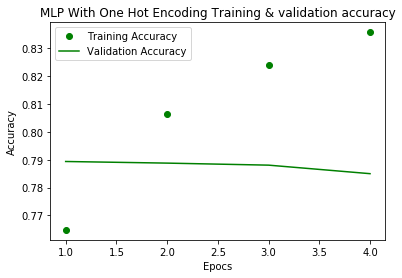

11455/11455 [==============================] - 10s 841us/step


In [15]:
modelName = 'best_mlp_one_hot_encoded_model.h5'
call_backs = [callbacks.EarlyStopping(monitor='val_acc', patience=3),
             callbacks.ModelCheckpoint(filepath=modelName, monitor='val_acc', save_best_only=True)]
mlpModel.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])
mlpModelHistory = mlpModel.fit(x_train, y_train, epochs=5, callbacks=call_backs, validation_data=(x_val,y_val))
plotTrainValidationAccuracy(model_history=mlpModelHistory, name="MLP With One Hot Encoding")
best_model = models.load_model(modelName)
create_test_submission_file(best_model.predict_classes(x_test),  "test_mlp_one_hot_encoded_model.csv")